Accuracy: 0.1027058481233634
Precision: 0.010270584812333351
Recall: 0.09999999999971672
F1 Score: 0.018627968320828074
Sample Test Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicted Label: 0


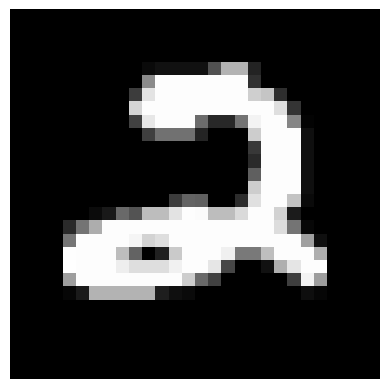

np.int64(0)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

class LogisticRegressionScratch:
    def __init__(self, lr=0.1, epochs=1500):
        self.lr = lr
        self.epochs = epochs

    def fit(self, X, y, num_classes):
        n, d = X.shape
        self.num_classes = num_classes
        self.W = np.zeros((num_classes, d))
        self.b = np.zeros(num_classes)

        for c in range(num_classes):
            y_c = (y == c).astype(int)
            w = np.zeros(d)
            b = 0

            for _ in range(self.epochs):
                z = X @ w + b
                p = sigmoid(z)
                dw = (X.T @ (p - y_c)) / n
                db = np.sum(p - y_c) / n
                w -= self.lr * dw
                b -= self.lr * db

            self.W[c] = w
            self.b[c] = b

    def predict(self, X):
        logits = X @ self.W.T + self.b
        probs = sigmoid(logits)
        return np.argmax(probs, axis=1)

    def predict_single(self, x):
        logits = x @ self.W.T + self.b
        probs = sigmoid(logits)
        return np.argmax(probs)

def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision_score(y_true, y_pred, num_classes):
    values = []
    for c in range(num_classes):
        TP = np.sum((y_true == c) & (y_pred == c))
        FP = np.sum((y_true != c) & (y_pred == c))
        values.append(TP / (TP + FP + 1e-9))
    return np.mean(values)

def recall_score(y_true, y_pred, num_classes):
    values = []
    for c in range(num_classes):
        TP = np.sum((y_true == c) & (y_pred == c))
        FN = np.sum((y_true == c) & (y_pred != c))
        values.append(TP / (TP + FN + 1e-9))
    return np.mean(values)

def f1_score(y_true, y_pred, num_classes):
    values = []
    for c in range(num_classes):
        TP = np.sum((y_true == c) & (y_pred == c))
        FP = np.sum((y_true != c) & (y_pred == c))
        FN = np.sum((y_true == c) & (y_pred != c))
        precision = TP / (TP + FP + 1e-9)
        recall = TP / (TP + FN + 1e-9)
        values.append(2 * precision * recall / (precision + recall + 1e-9))
    return np.mean(values)

def array_to_image(pixel_array):
    img = pixel_array.reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.show()
    return img

def predict_and_show(pixel_array, model):
    x = pixel_array / 255.0
    label = model.predict_single(x)
    print("Predicted Label:", label)
    array_to_image(pixel_array)
    return label

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

y_train = train_df.iloc[:, 0].values
X_train = train_df.iloc[:, 1:].values / 255.0
X_test = test_df.values / 255.0

num_classes = 10
model = LogisticRegressionScratch(lr=0.1, epochs=1500)
model.fit(X_train, y_train, num_classes)

y_pred_train = model.predict(X_train)

print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("Precision:", precision_score(y_train, y_pred_train, num_classes))
print("Recall:", recall_score(y_train, y_pred_train, num_classes))
print("F1 Score:", f1_score(y_train, y_pred_train, num_classes))

test_predictions = model.predict(X_test)
print("Sample Test Predictions:", test_predictions[:20])

sample = X_test[0]
predict_and_show(sample, model)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder


df = pd.read_csv("bank-full.csv", sep=';', engine='python', on_bad_lines='warn')

for col in df.columns:
    if df[col].dtype == "object":
        df[col] = LabelEncoder().fit_transform(df[col])

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

X = df.drop("y", axis=1).values
y = df["y"].values

split = int(0.8 * len(df))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


class NaiveBayesScratch:
    def fit(self, X, y):
        n, d = X.shape
        self.classes = np.unique(y)
        self.mean = {}
        self.var = {}
        self.priors = {}

        for c in self.classes:
            X_c = X[y == c]
            self.mean[c] = X_c.mean(axis=0)
            self.var[c] = X_c.var(axis=0) + 1e-9
            self.priors[c] = len(X_c) / n

    def gaussian(self, x, mean, var):
        num = np.exp(-((x - mean) ** 2) / (2 * var))
        den = np.sqrt(2 * np.pi * var)
        return num / den

    def predict_single(self, x):
        posteriors = {}
        for c in self.classes:
            prior = np.log(self.priors[c])
            likelihood = np.sum(np.log(self.gaussian(x, self.mean[c], self.var[c])))
            posteriors[c] = prior + likelihood
        return max(posteriors, key=posteriors.get)

    def predict(self, X):
        return np.array([self.predict_single(x) for x in X])


model = NaiveBayesScratch()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


def confusion_matrix(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    return TP, FP, TN, FN


TP, FP, TN, FN = confusion_matrix(y_test, y_pred)

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP + 1e-9)
recall = TP / (TP + FN + 1e-9)
f1 = 2 * precision * recall / (precision + recall + 1e-9)

print("TP:", TP, "FP:", FP)
print("TN:", TN, "FN:", FN)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

TP: 555 FP: 900
TN: 7080 FN: 508
Accuracy: 0.8442994581444211
Precision: 0.38144329896881
Recall: 0.5221072436495559
F1 Score: 0.44082605193432545
